# Import needed modules

In [1]:
!pip install tensorflow==2.9.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 1.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 79.8 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 80.6 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 50.6 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.3.3
    Uninstalling flatbuffers-23.3.3:
      Successfully uninstalled flatbuffers-23.3.3
  Attemp

In [2]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# **Data Preprocessing**

### **Read data and store it in dataframe**

In [3]:
# Generate data paths with labels
data_dir = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [4]:
df

filepaths     labels
0     /kaggle/input/lung-and-colon-cancer-histopatho...  colon_aca
1     /kaggle/input/lung-and-colon-cancer-histopatho...  colon_aca
2     /kaggle/input/lung-and-colon-cancer-histopatho...  colon_aca
3     /kaggle/input/lung-and-colon-cancer-histopatho...  colon_aca
4     /kaggle/input/lung-and-colon-cancer-histopatho...  colon_aca
...                                                 ...        ...
9995  /kaggle/input/lung-and-colon-cancer-histopatho...    colon_n
9996  /kaggle/input/lung-and-colon-cancer-histopatho...    colon_n
9997  /kaggle/input/lung-and-colon-cancer-histopatho...    colon_n
9998  /kaggle/input/lung-and-colon-cancer-histopatho...    colon_n
9999  /kaggle/input/lung-and-colon-cancer-histopatho...    colon_n

[10000 rows x 2 columns]

### **Split dataframe into train, valid, and test**

In [5]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

### **Create image data generator**

In [6]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 8000 validated image filenames belonging to 2 classes.
Found 1200 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.


### **Show sample from train data**

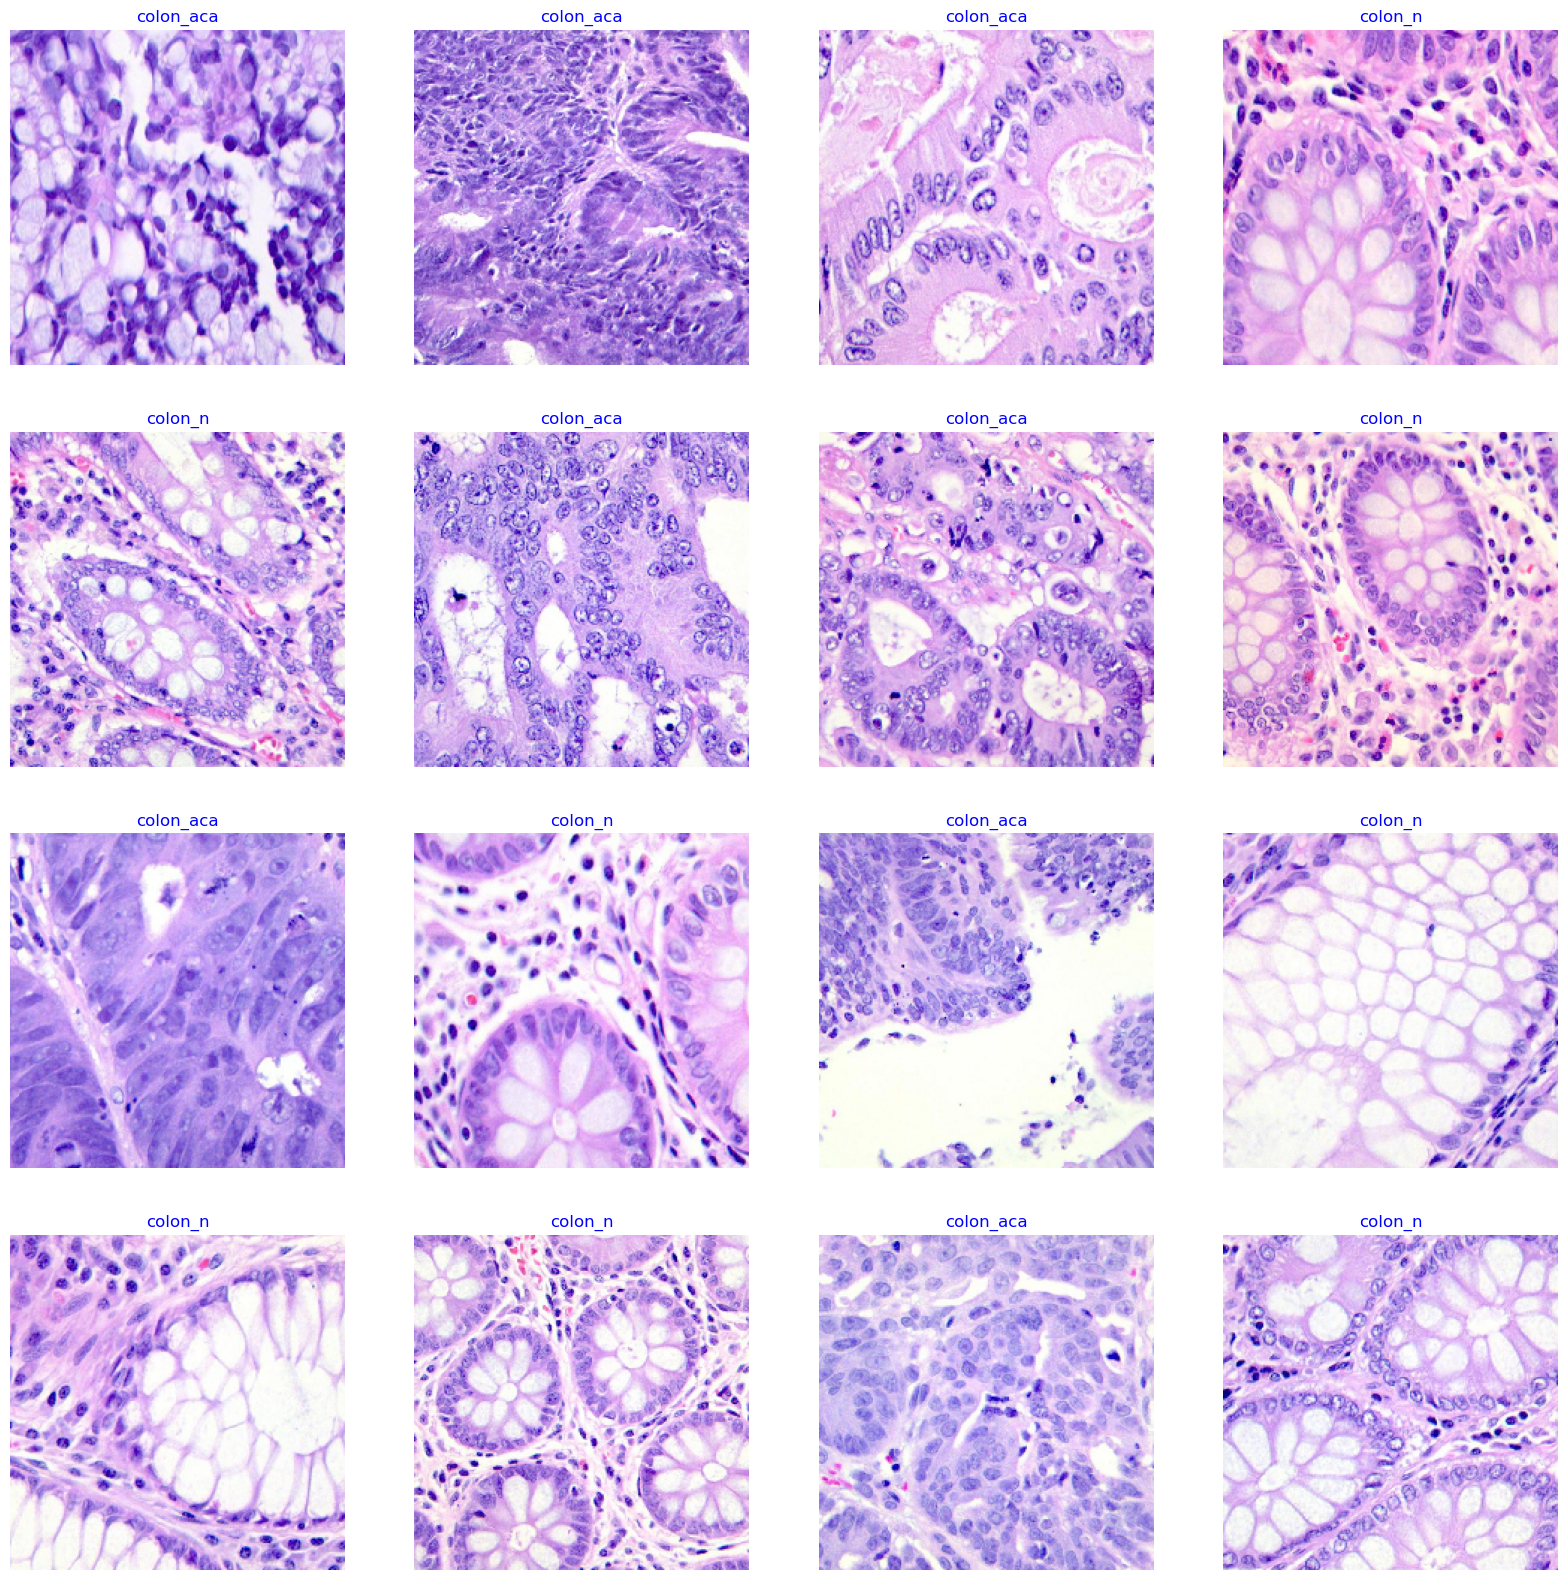

In [7]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

# **Model Structure**

#### **Generic Model Creation**

In [8]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

43941136/43941136 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization (BatchN  (None, 1536)             6144      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 11,183,665
Trainable params: 11,093,290
Non

#### **Train model**

In [9]:
epochs = 10   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, 
                    validation_steps= None, shuffle= False)

Epoch 1/10
500/500 [==============================] - 153s 264ms/step - loss: 3.2305 - accuracy: 0.9799 - val_loss: 1.3480 - val_accuracy: 1.0000
Epoch 2/10
500/500 [==============================] - 126s 252ms/step - loss: 0.7888 - accuracy: 0.9956 - val_loss: 0.4052 - val_accuracy: 1.0000
Epoch 3/10
500/500 [==============================] - 126s 252ms/step - loss: 0.2813 - accuracy: 0.9994 - val_loss: 0.1702 - val_accuracy: 1.0000
Epoch 4/10
500/500 [==============================] - 125s 250ms/step - loss: 0.1454 - accuracy: 0.9991 - val_loss: 0.1076 - val_accuracy: 1.0000
Epoch 5/10
500/500 [==============================] - 126s 251ms/step - loss: 0.1010 - accuracy: 0.9998 - val_loss: 0.0761 - val_accuracy: 1.0000
Epoch 6/10
500/500 [==============================] - 125s 250ms/step - loss: 0.0814 - accuracy: 0.9998 - val_loss: 0.0614 - val_accuracy: 1.0000
Epoch 7/10
500/500 [==============================] - 125s 250ms/step - loss: 0.0695 - accuracy: 0.9999 - val_loss: 0.0546 -

#### **Display model performance**

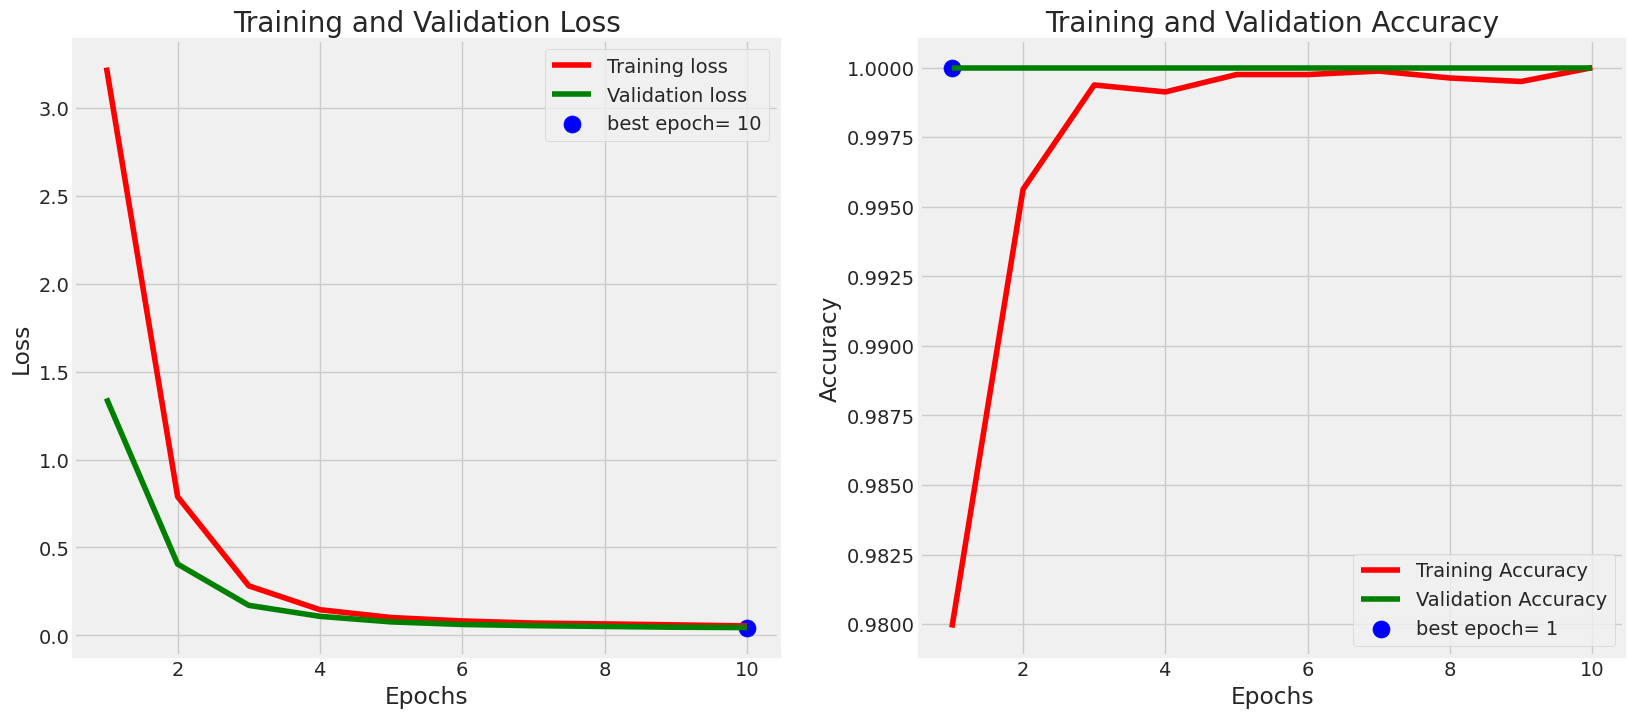

In [10]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# **Evaluate model**

In [11]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

10/10 [==============================] - 2s 193ms/step - loss: 0.0434 - accuracy: 1.0000
Train Loss:  0.04363403469324112
Train Accuracy:  1.0
--------------------
Validation Loss:  0.04311935976147652
Validation Accuracy:  1.0
--------------------
Test Loss:  0.04335950314998627
Test Accuracy:  1.0


# **Get Predictions**

In [12]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

#### **Confusion Matrics and Classification Report**

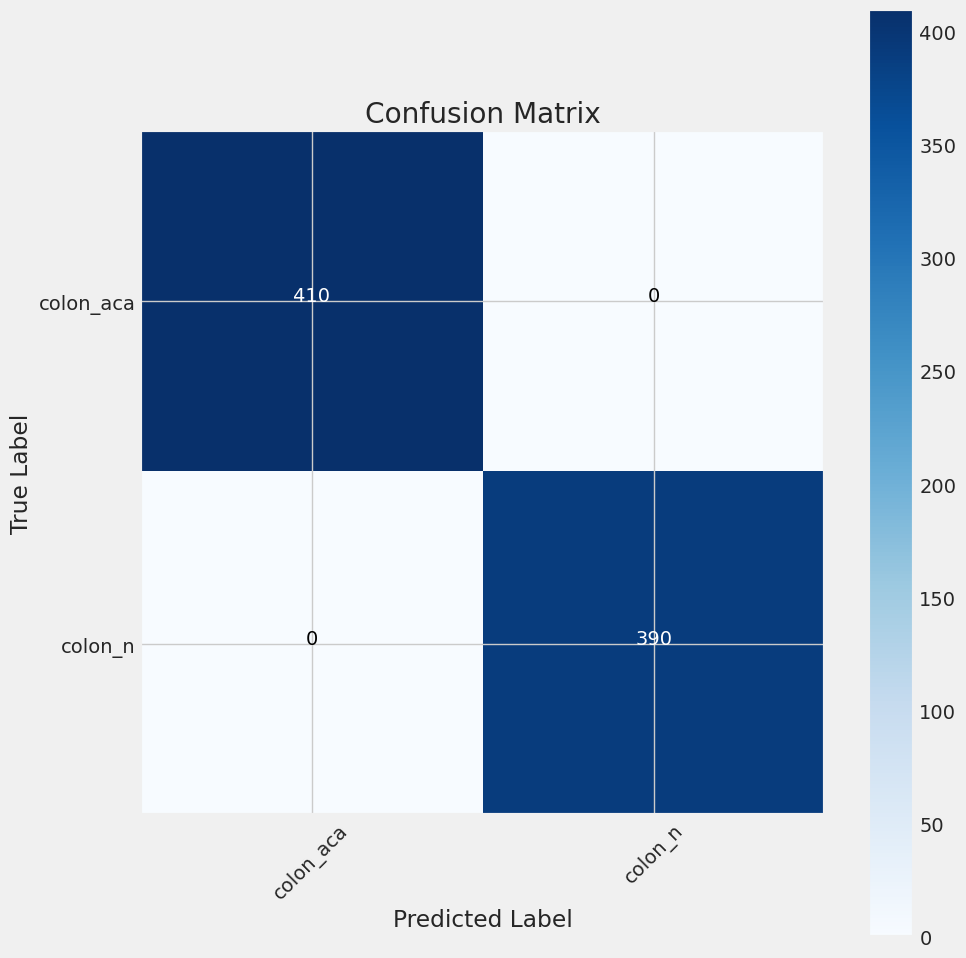

In [13]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [14]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

   colon_aca       1.00      1.00      1.00       410
     colon_n       1.00      1.00      1.00       390

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



#### **Save model**

In [15]:
#Save the model
model.save('Colon Cancer.h5')

## **Prediction using loaded_model**

In [16]:
loaded_model = tf.keras.models.load_model('/kaggle/working/Colon Cancer.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [17]:
image_path = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca1001.jpeg'
image = Image.open(image_path)
# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = ['Colon_ACA', 'Lung_N']
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 2s 2s/step
Colon_ACA


## Convert to tflite

In [18]:
converter = tf.lite.TFLiteConverter.from_keras_model(model) 
tflite_model = converter.convert() 

print("model converted")

# Save the model. 
with open('Colon.tflite', 'wb') as f:
    f.write(tflite_model)

model converted
